<a href="https://colab.research.google.com/github/abdullah-imtiaz/German-Traffic-Signs-Classifier/blob/master/Traffic_Signs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **German Traffic Signs Classifier**


---

**Training Accuracy:**      0.9723 * 100 
                    
**Test Accuracy:**          0.9698 * 100 



In [42]:
%tensorflow_version 2.x       #Run this cell if Tensorflow version lower than 2.0, you can check it by running cell next to Imports.

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x       #Run this cell if Tensorflow version lower than 2.0, you can check it by running cell next to Imports.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


## **Imports**

In [0]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import random
import cv2
import requests
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

style.use('seaborn')


In [44]:
tf.__version__

'2.1.0'

## **Loading Pickled Data**

[Dataset](https://http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

In [0]:
'''
### Note ###
# You can download pickled files from the repository. 
'''
with open('german-traffic-signs/train.p', 'rb') as f:                           #Proper path to the file
  train_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:                            #Proper path to the file
  test_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:                           #Proper path to the file
  validation_data = pickle.load(f)

## **Features and Labels**


In [0]:
X_train, y_train = train_data['features'], train_data['labels'] 
X_test, y_test = test_data['features'], test_data['labels']
X_validation, y_validation = validation_data['features'], validation_data['labels']


## **Csv File for Traffic Sign Names**

In [0]:
df = pd.read_csv('german-traffic-signs/signnames.csv')

## **Looping Over Data, Displaying Random Images From Each Class**


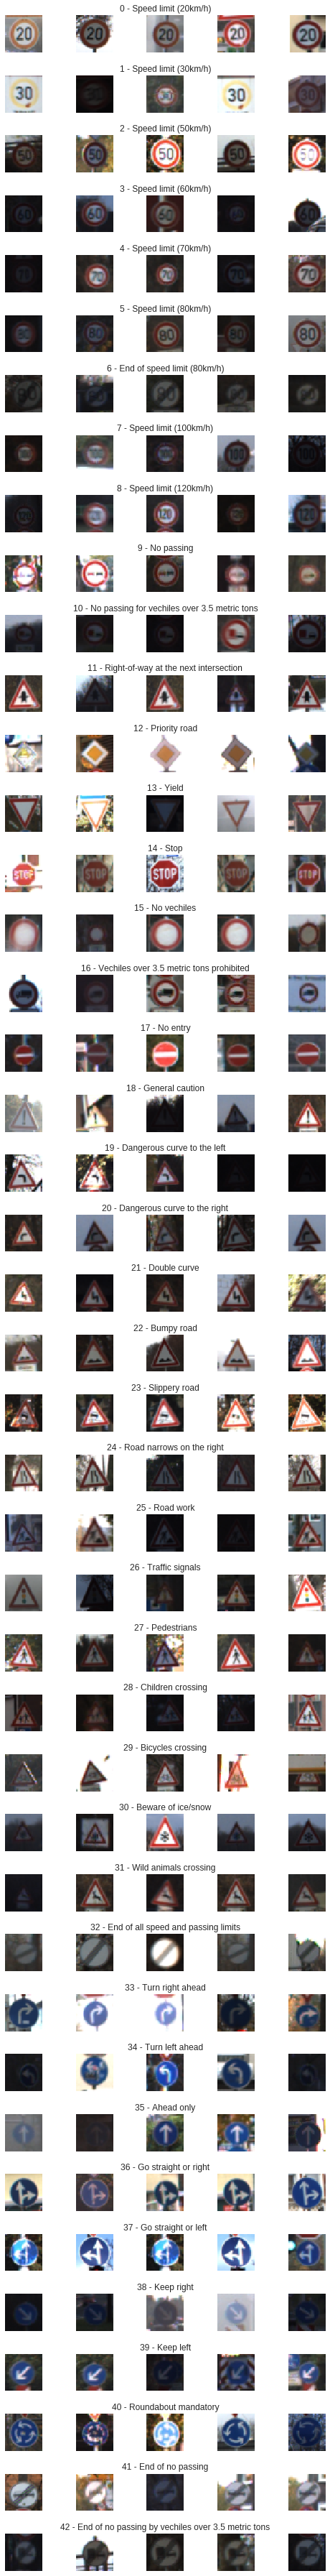

In [49]:
total_samples = []

classes = len(df['SignName'].unique())
columns = 5

figure, axs = plt.subplots(nrows=classes, ncols= columns, figsize=(7, 50))
figure.tight_layout()

for col in range(columns):
  for row, data in df.iterrows():
    X_selected = X_train[y_train == row]
    axs[row][col].imshow(X_selected[random.randint(0, (len(X_selected) - 1))], cmap = plt.get_cmap('gray'))
    axs[row][col].axis('off')
    if col == 2:
      axs[row][col].set_title(f'{str(row)} - {data["SignName"]}')
      total_samples.append(len(X_selected))

## **Distribution of Data across Distinct Classes**


Text(0.5, 0, 'Class')

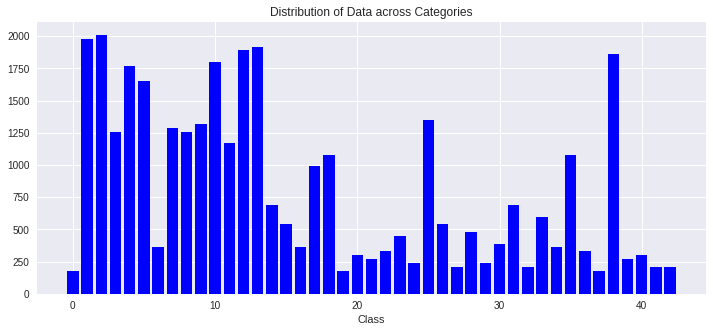

In [50]:
plt.figure(figsize=(12, 5))
plt.bar(range(0, classes), total_samples, color = 'b')
plt.title('Distribution of Data across Categories')
plt.xlabel('Class')

## **Preprocessing Images**

In [0]:
#1). Gray Scale.   2). Histrogram Distribution Over Gray Scale Images   3). Scaling Images(Normalizing)  
def preprocessing_images(image):
  gray_scaled_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist_equalized_image = cv2.equalizeHist(gray_scaled_image)
  hist_equalized_image = hist_equalized_image / 255
  return hist_equalized_image


(32, 32)


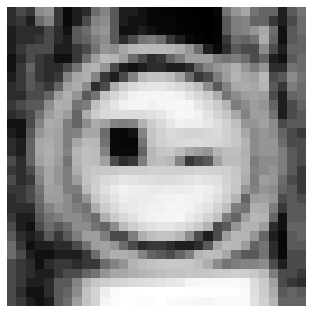

In [52]:
img = preprocessing_images(X_train[random.randint(0, len(X_train) - 1 )])
plt.imshow(img, cmap= plt.get_cmap('gray'))
plt.axis('off')
print(img.shape)

## **Mapping the "preprocessing_images" function over all Images**


In [0]:
#(Train, Test, Validation)
X_train = np.array(list(map(preprocessing_images, X_train)))
X_test = np.array(list(map(preprocessing_images, X_test)))
X_validation = np.array(list(map(preprocessing_images, X_validation)))

In [54]:
X_train.shape

(34799, 32, 32)

(-0.5, 31.5, 31.5, -0.5)

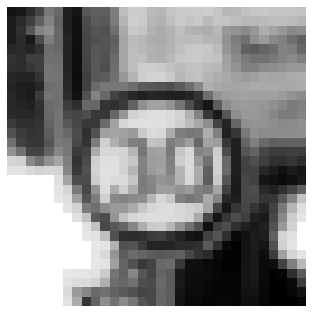

In [55]:
plt.imshow(X_train[random.randint(0, len(X_train)-1 )], cmap= plt.get_cmap('gray'))
plt.axis('off')

## **Reshaping Data**

In [0]:
# Adding the color channel dimention, in gray scale images only 1.

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_validation = X_validation.reshape(4410, 32, 32, 1)

## **One Hot Encoding**

In [0]:
#Labels

y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)
y_validation = to_categorical(y_validation, num_classes=43)

## **Model Architecture** 






In [0]:
'''
### NOTE ###
# Base Model is LeNet with 2 Additional Cnvolutional Layers. (Filters too are distinct from the original model architecture)
# Dropout Layers
# Additional Layers are Labeled.
'''
def model_():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation='relu'))    #60 Filters instead of 30  
  model.add(Conv2D(60, (5, 5), activation='relu'))                               #Additional Layer
  
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))                               #30 Filters. Original 15.
  model.add(Conv2D(30, (3, 3), activation='relu'))                               #Additional Layer

  model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Flatten())
  
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(43, activation='softmax'))                                     #Output Layer

  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [59]:
model = model_()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

## **Image Data Generator**

In [0]:
#DATA AUGMENTATION (Creating Training Images, Increasing Training Images Data)

data_generator = ImageDataGenerator(width_shift_range= 0.1, 
                                    height_shift_range = 0.1,
                                    rotation_range = 10,
                                    shear_range = 0.1)

In [0]:
#Fitting the Data Generator
data_generator.fit(X_train)

## **Data after Transformation**

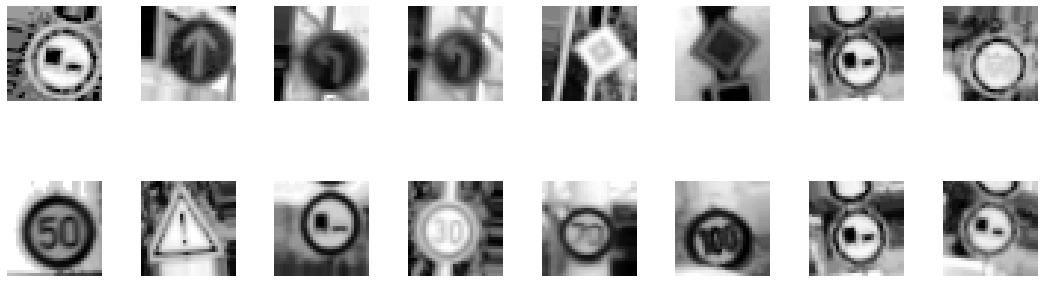

In [62]:
#Augmented Data

batches = data_generator.flow(X_train, y_train, batch_size=30)
X_batch, y_batch = next(batches)

figure, axs = plt.subplots(2, 8, figsize= (15, 5))
figure.tight_layout()

for i in range(2):
  for j in range(8):
    axs[i][j].imshow(X_batch[random.randint(0, len(X_batch) -1 )].reshape(32, 32), cmap = plt.get_cmap('gray'))
    axs[i][j].axis('off')

## **Training**

In [63]:
model.fit(data_generator.flow(X_train, y_train, batch_size=32),  steps_per_epoch=len(X_train) / 32, 
                                        epochs= 10, validation_data=(X_validation, y_validation),
                                        shuffle =True)

  ...
    to  
  ['...']
Train for 1087.46875 steps, validate on 4410 samples
Epoch 1/10
1088/1087 [==============================] - 13s 12ms/step - loss: 1.5387 - accuracy: 0.5598 - val_loss: 0.2880 - val_accuracy: 0.9138
Epoch 2/10
1088/1087 [==============================] - 13s 12ms/step - loss: 0.4298 - accuracy: 0.8661 - val_loss: 0.1306 - val_accuracy: 0.9628
Epoch 3/10
1088/1087 [==============================] - 13s 12ms/step - loss: 0.2570 - accuracy: 0.9206 - val_loss: 0.0972 - val_accuracy: 0.9753
Epoch 4/10
1088/1087 [==============================] - 13s 12ms/step - loss: 0.1929 - accuracy: 0.9405 - val_loss: 0.0730 - val_accuracy: 0.9778
Epoch 5/10
1088/1087 [==============================] - 13s 12ms/step - loss: 0.1579 - accuracy: 0.9511 - val_loss: 0.0880 - val_accuracy: 0.9735
Epoch 6/10
1088/1087 [==============================] - 13s 12ms/step - loss: 0.1325 - accuracy: 0.9595 - val_loss: 0.0870 - val_accuracy: 0.9796
Epoch 7/10
1088/1087 [========================

### **Training History**

In [0]:
metrics = pd.DataFrame(model.history.history)

In [65]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.538995,0.559815,0.287985,0.913832
1,0.429733,0.866146,0.130563,0.962812
2,0.257088,0.920572,0.097217,0.975283
3,0.192952,0.940544,0.072963,0.977778
4,0.157918,0.951119,0.087964,0.973469
5,0.132503,0.959482,0.087029,0.979592
6,0.119608,0.962873,0.080026,0.979819
7,0.113645,0.964625,0.088984,0.980272
8,0.104471,0.968189,0.059067,0.983447
9,0.088786,0.972298,0.042159,0.986621


### **Loss**

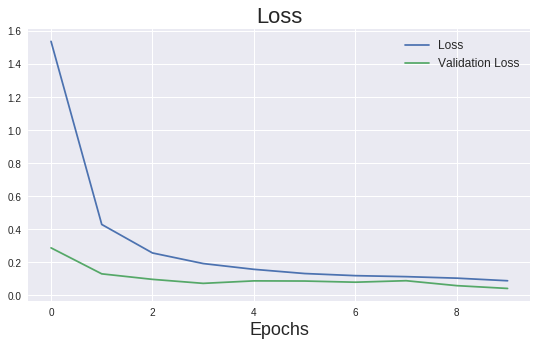

In [66]:
plt.figure(figsize = (9,5))
plt.title('Loss', fontsize = 22)
plt.xlabel('Epochs', fontsize = 18)
plt.plot(metrics['loss'], label = 'Loss')
plt.plot(metrics['val_loss'], label = 'Validation Loss')
plt.legend(prop={'size': 12})

### **Accuracy**

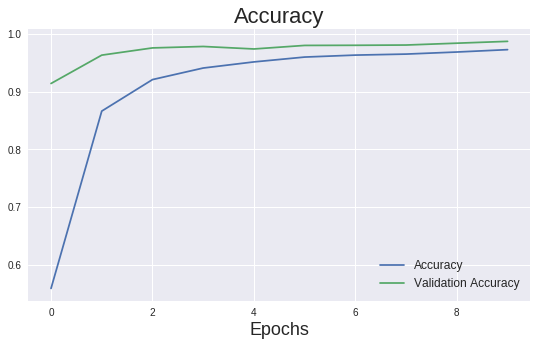

In [67]:
plt.figure(figsize = (9, 5))
plt.title('Accuracy', fontsize = 22)
plt.xlabel('Epochs', fontsize = 18)
plt.plot(metrics['accuracy'], label = 'Accuracy')
plt.plot(metrics['val_accuracy'], label = 'Validation Accuracy')
plt.legend(prop = {"size": 12})

## **Test Score**

In [68]:
test_score = model.evaluate(X_test, y_test)


12630/12630 [==============================] - 1s 110us/sample - loss: 0.1199 - accuracy: 0.9698


In [69]:
# print(test_score[0])
print('Test Accuracy: ', test_score[1])

Test Accuracy:  0.96983373


## **Predictions**

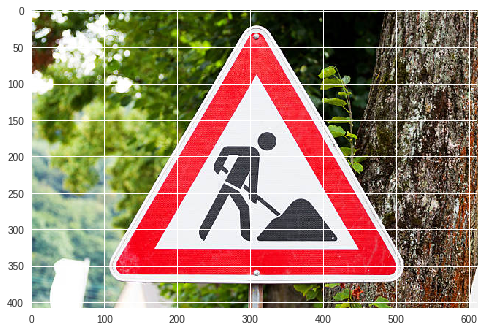

In [70]:
url = 'https://media.istockphoto.com/photos/german-road-sign-for-construction-works-picture-id532189779?k=6&m=532189779&s=612x612&w=0&h=iWNSAFHYi1CNFtDkLpgWEDWWK06viBf9gTEl5yWB_bo='
r = requests.get(url, stream = True)
img = Image.open(r.raw)
plt.imshow(img)

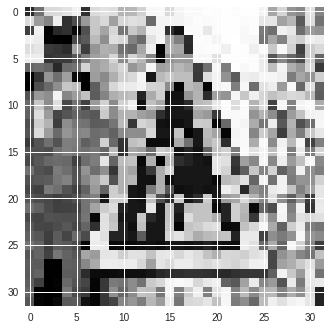

In [71]:
img = np.asarray(img)
img = cv2.resize(img, (32,32))             #Reducing the size to original data size images. 
img = preprocessing_images(img)            # Function defined above
plt.imshow(img)


In [72]:
img = img.reshape(1, 32, 32, 1)            #Reshaping for Convolutional layers
print(f'Predicted Image:  {str(model.predict_classes(img))}')
df.iloc[int(model.predict_classes(img))]

Predicted Image:  [25]


ClassId            25
SignName    Road work
Name: 25, dtype: object

## **What Convolutional Layers see!**




In [73]:
layer1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
layer2 = Model(inputs=model.layers[0].input, outputs=model.layers[1].output)

visual_layer1, visual_layer2 = layer1.predict(img), layer2.predict(img)

print(visual_layer1.shape)
print(visual_layer2.shape)

(1, 28, 28, 60)
(1, 24, 24, 60)


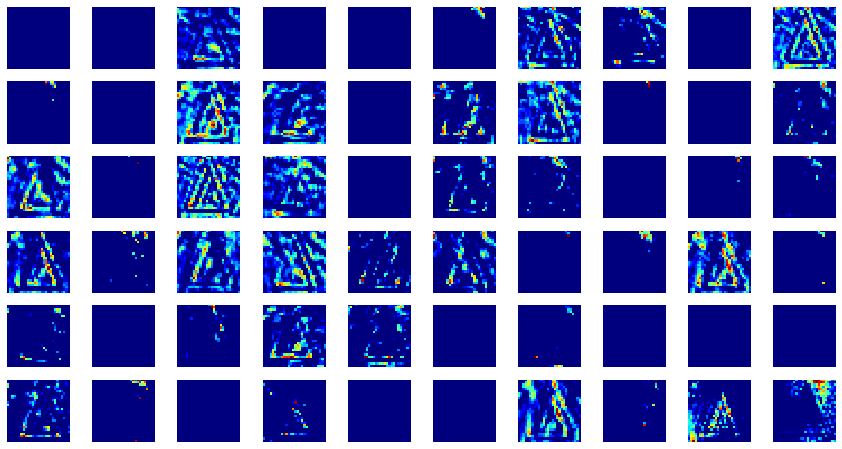

In [74]:
plt.figure(figsize=(15, 8))
for i in range(60):
    plt.subplot(6, 10, i+1)
    plt.imshow(visual_layer1[0, :, :, i], cmap=plt.get_cmap('jet'))
    plt.axis('off')

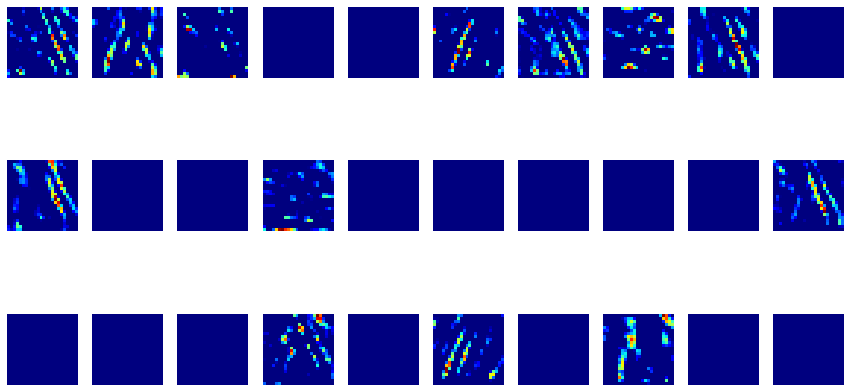

In [75]:
plt.figure(figsize=(15, 8))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(visual_layer2[0, :, :, i], cmap=plt.get_cmap('jet'))
    plt.axis('off')

## **Thank You!**